In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [2]:
# Set up the database connection
engine = create_engine("sqlite:///../reddit_posts.db")

In [3]:
# Read table
posts_df = pd.read_sql("posts_clean", engine)
posts_df.head()

,id,subreddit,title,selftext,date
0,c77jgf,investing,"Is ""The Big Short"" by Michael Lewis a good book?",I haven't read it yet.,2019-06-30
1,c78w4x,investing,Need help thinking through a long-term play on...,In the long run I am very bullish on renewable...,2019-06-30
2,c794e0,investing,Why chasing high yielding stocks is not the be...,[removed],2019-06-30
3,c796k7,investing,Auction.com Real Estate - Advice Needed!,[deleted],2019-06-30
4,c7994a,investing,Does anyone else think that Jim Rogers is righ...,He's predicting a more severe crash than 2008 ...,2019-06-30


In [4]:
comments_df = pd.read_sql("comments_clean", engine)
comments_df.head()

,id,subreddit,parent_id,body,date
0,esdguxz,geopolitics,None,Why none?,2019-06-30
1,esdhtud,geopolitics,None,&gt; Who is the realist?\n\nIt depends on what...,2019-06-30
2,esdi6lj,geopolitics,None,[removed],2019-06-30
3,esdi9eq,geopolitics,None,Vietnam is only a fraction of the size of Chin...,2019-06-30
4,esdilx8,geopolitics,None,"What is the ""West"" supposed to mean? The tradi...",2019-06-30


In [5]:
gold = pd.read_sql("gold", engine)
gold.head()

,date,Close,High,Low,Open,Volume
0,2019-06-27,1408.400024,1410.800049,1399.800049,1407.000000,437
1,2019-06-28,1409.699951,1422.000000,1408.300049,1408.300049,356
2,2019-07-01,1385.599976,1395.800049,1382.800049,1386.599976,214
3,2019-07-02,1404.599976,1418.400024,1390.800049,1391.099976,38
4,2019-07-03,1417.699951,1434.000000,1413.099976,1431.000000,46


In [6]:
print("Posts total:", len(posts_df))
print(posts_df["subreddit"].value_counts())
print()
print("Comments total:", len(comments_df))
print(comments_df["subreddit"].value_counts())

Posts total: 602915
subreddit
investing              241895
PoliticalDiscussion     99208
Economics               91537
finance                 64111
Gold                    58488
geopolitics             47676
Name: count, dtype: int64

Comments total: 3701503
subreddit
PoliticalDiscussion    2686442
geopolitics            1015061
Name: count, dtype: int64


In [7]:
for df, name in [(posts_df, "posts"), (comments_df, "comments"), (gold, "gold")]:
    dates = df['date']
    print(f"{name}: {dates.min()} → {dates.max()}")

posts: 2019-06-30 00:00:00 → 2024-12-31 00:00:00
comments: 2019-06-30 00:00:00 → 2024-12-31 00:00:00
gold: 2019-06-27 00:00:00 → 2025-06-27 00:00:00


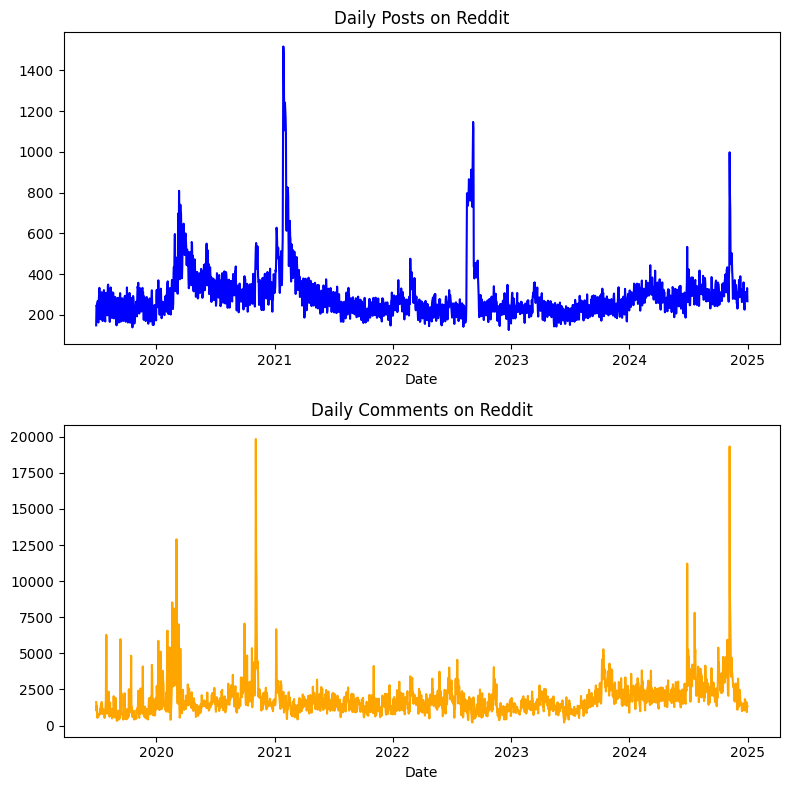

In [8]:
daily_posts    = posts_df.groupby("date").size()
daily_comments = comments_df.groupby("date").size()

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(daily_posts, label="Posts", color='blue')
plt.title("Daily Posts on Reddit")
plt.xlabel("Date")

plt.subplot(2, 1, 2)
plt.plot(daily_comments, label="Comments", color='orange')
plt.title("Daily Comments on Reddit")
plt.xlabel("Date")
plt.tight_layout()

<Axes: title={'center': 'Posts by Subreddit'}, xlabel='date'>

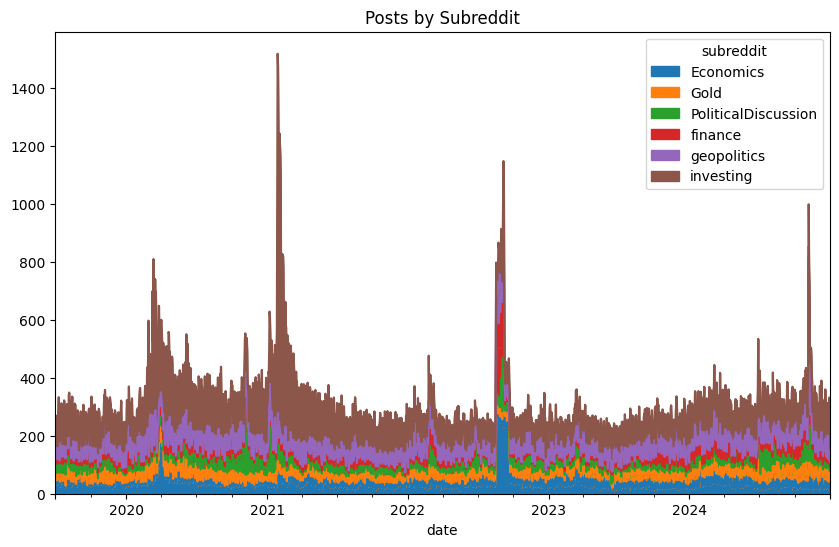

In [9]:
pd.crosstab(posts_df["date"], posts_df["subreddit"]).plot(
    figsize=(10,6), title="Posts by Subreddit", kind='area'
)


Text(0.5, 1.0, 'Character Length of Comments')

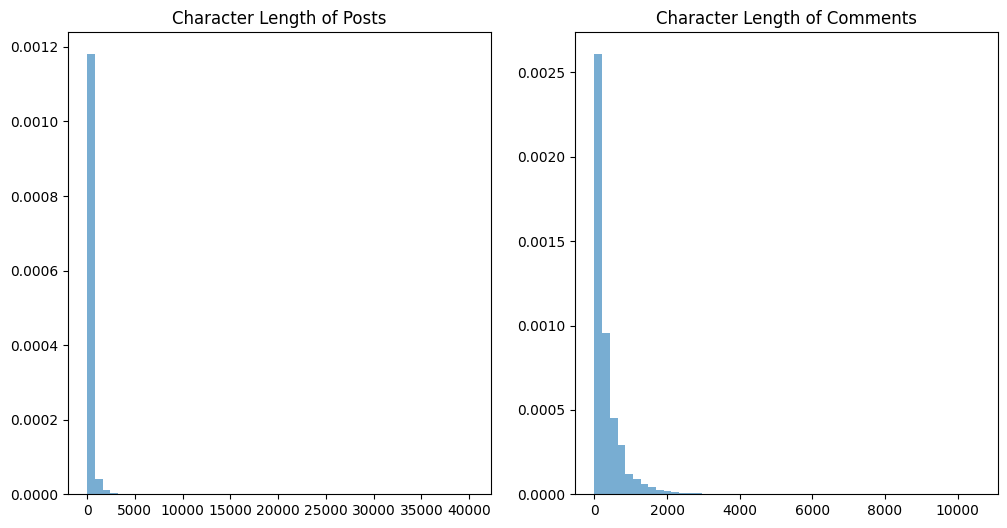

In [10]:
posts_df["char_len"]    = posts_df["title"].str.len() + posts_df["selftext"].str.len()
comments_df["char_len"] = comments_df["body"].str.len()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(posts_df["char_len"], bins=50, density=True, alpha=0.6);
plt.title("Character Length of Posts")

plt.subplot(1, 2, 2)
plt.hist(comments_df["char_len"], bins=50, density=True, alpha=0.6);
plt.title("Character Length of Comments")

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter

# 1. Download required NLTK data (run once)
nltk.download("punkt")
nltk.download("stopwords")

# 2. Build our stop-word set
stop_words = set(stopwords.words("english"))
extras = ['reddit', 'gold', 'com', 'www', 'https', 'removed', 'invest']

stop_words |= set(extras)

def tokenize_and_clean(text):
    # a) lowercase & word tokenize
    tokens = word_tokenize(text.lower())
    # b) keep only alpha tokens ≥3 chars, not in stop_words
    return [
        tok for tok in tokens
        if tok.isalpha() and len(tok) >= 3 and tok not in stop_words
    ]

# 3. Aggregate across all posts’ selftext
all_texts = posts_df["selftext"].fillna("")

# 4. Unigrams
all_unigrams = []
for txt in all_texts:
    all_unigrams.extend(tokenize_and_clean(txt))
uni_counts = Counter(all_unigrams)
print("Top 20 unigrams:")
print(uni_counts.most_common(20), "\n")

# 5. Bigrams
all_bigrams = []
for txt in all_texts:
    toks = tokenize_and_clean(txt)
    all_bigrams.extend(ngrams(toks, 2))
bi_counts = Counter(all_bigrams)
print("Top 20 bigrams:")
print([(" ".join(bg), c) for bg, c in bi_counts.most_common(20)], "\n")

# 6. Trigrams
all_trigrams = []
for txt in all_texts:
    toks = tokenize_and_clean(txt)
    all_trigrams.extend(ngrams(toks, 3))
tri_counts = Counter(all_trigrams)
print("Top 20 trigrams:")
print([(" ".join(tg), c) for tg, c in tri_counts.most_common(20)])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/AnshulSrivastava/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/AnshulSrivastava/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 20 unigrams:
[('would', 55856), ('like', 42778), ('market', 33211), ('deleted', 32717), ('money', 29368), ('stock', 26101), ('also', 25622), ('one', 24789), ('time', 24452), ('years', 23936), ('amp', 23325), ('know', 23268), ('year', 22865), ('company', 22092), ('get', 21045), ('could', 20899), ('buy', 20626), ('think', 20485), ('people', 19954), ('much', 19760)] 

Top 20 bigrams:
[('amp amp', 7613), ('long term', 5364), ('would like', 5137), ('roth ira', 4274), ('stock market', 4012), ('seems like', 3161), ('interest rate', 3093), ('interest rates', 2971), ('real estate', 2640), ('united states', 2383), ('risk tolerance', 2345), ('need money', 2309), ('personal situation', 2307), ('time horizon', 2298), ('buy house', 2294), ('next month', 2240), ('money buy', 2175), ('need know', 2174), ('retirement savings', 2159), ('last year', 2109)] 

Top 20 trigrams:
[('amp amp amp', 5615), ('money buy house', 2011), ('need money next', 2006), ('buy house retirement', 1996), ('risk tolerance 

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

# 1. Prepare your corpus
posts_self = posts_df["selftext"].fillna("").tolist()
posts_title = posts_df["title"].fillna("").tolist()
corpus = posts_self + posts_title
extras = ['reddit', 'gold', 'com', 'www', 'https', 'removed', 'invest']

def top_ngrams(corpus, ngram_range=(1,1), top_n=20, extra_stopwords=None):
    """
    Returns a DataFrame of the top_n n-grams in the corpus for the given ngram_range.
    """
    stop_words = set(ENGLISH_STOP_WORDS)
    if extra_stopwords:
        stop_words |= set(extra_stopwords)

    stop_list = list(stop_words)
    vec = CountVectorizer(
        stop_words=stop_list,
        token_pattern=r"\b\w{3,}\b",
        ngram_range=ngram_range,
        max_features=top_n
    )
    X = vec.fit_transform(corpus)
    freqs = X.sum(axis=0).A1
    terms = vec.get_feature_names_out()
    return pd.DataFrame({
        "ngram": terms,
        "count": freqs
    }).sort_values("count", ascending=False)

# 2. Compute & display
top_uni   = top_ngrams(corpus, (1,1), top_n=20, extra_stopwords=extras)
top_bi    = top_ngrams(corpus, (2,2), top_n=20, extra_stopwords=extras)
top_tri   = top_ngrams(corpus, (3,3), top_n=20, extra_stopwords=extras)

print("Top 20 Unigrams:")
print(top_uni.to_string(index=False))

print("\nTop 20 Bigrams:")
print(top_bi.to_string(index=False))

print("\nTop 20 Trigrams:")
print(top_tri.to_string(index=False))


Top 20 Unigrams:
     ngram  count
      like  53888
    market  53753
      just  51647
     stock  47714
 investing  46184
     money  44800
   deleted  39736
       new  37775
      year  36550
    stocks  36060
      time  36023
       buy  34067
       amp  33727
     years  32269
     think  31295
      know  31027
    people  30585
investment  28863
      does  28802
   company  28481

Top 20 Bigrams:
                      ngram  count
                  long term  12855
                   roth ira   8877
               stock market   8852
               deleted user   6926
                  amp x200b   6491
                real estate   5380
fintechinshorts fintechnews   5008
              united states   4865
        fintechnews tinyurl   4684
                 short term   4516
            content uploads   4513
                   don know   4408
    fintechinshorts content   4268
             investing wiki   3619
                index funds   3484
                    amp 500 

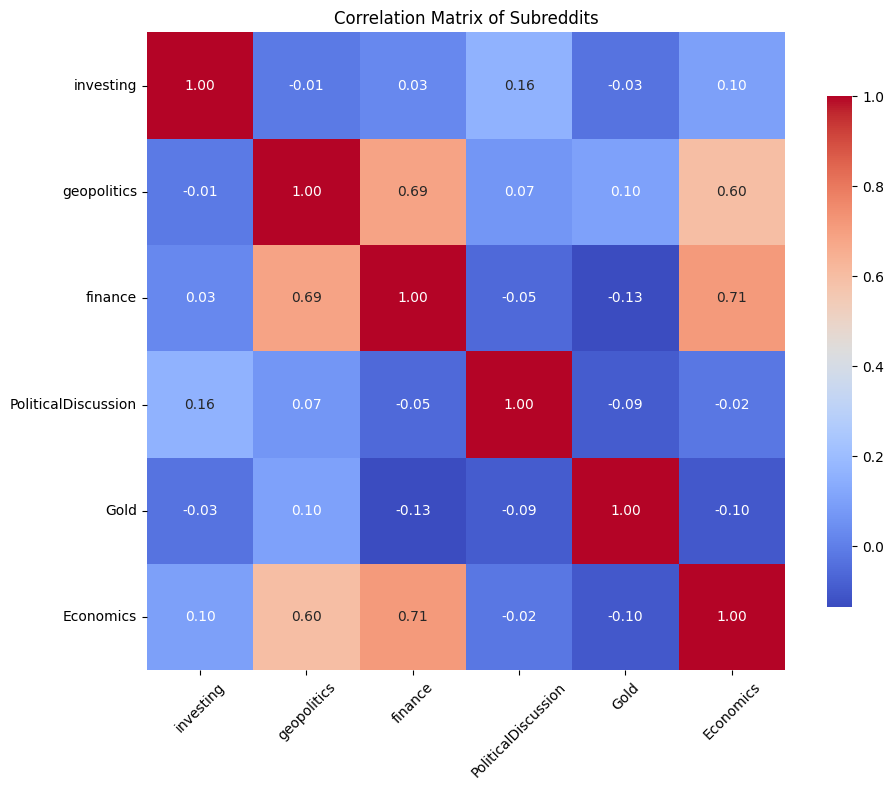

In [11]:
vol = pd.DataFrame({
    sub: posts_df.loc[posts_df.subreddit==sub].groupby("date").size()
    for sub in posts_df["subreddit"].unique()
}).fillna(0)
m = vol.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
import seaborn as sns
sns.heatmap(m, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Subreddits")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

<Axes: title={'center': '30-day Rolling Avg of Posts'}, xlabel='date'>

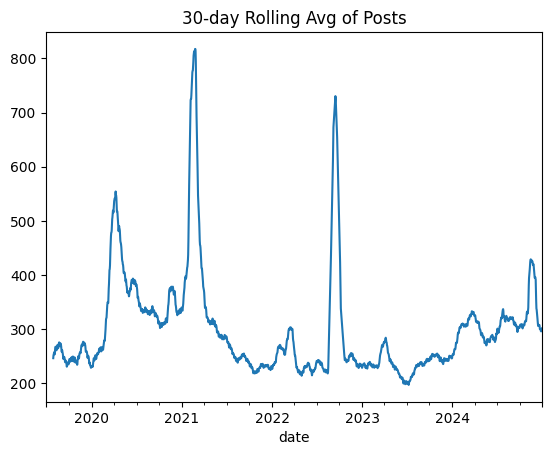

In [12]:
daily_posts.rolling(30).mean().plot(title="30-day Rolling Avg of Posts")

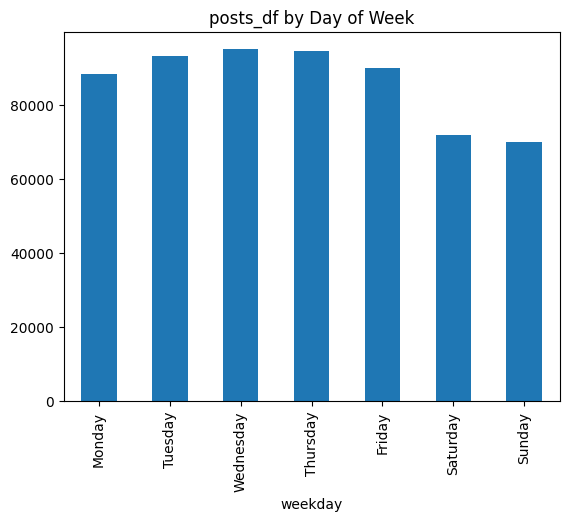

In [13]:
posts_df["weekday"] = pd.to_datetime(posts_df.date).dt.day_name()
posts_df.groupby("weekday").size().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
).plot(kind="bar", title="posts_df by Day of Week");

In [14]:
import re
import html

URL_RE    = re.compile(r"https?://\S+|www\.\S+")
MENTION_RE= re.compile(r"/?u/[A-Za-z0-9_-]+")
HTML_RE   = re.compile(r"&\w+;")
SPACE_RE  = re.compile(r"\s+")
DELETED_RE = re

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text.strip().lower()
    if t in ["[deleted]", "[removed]"]:
        return ""
    # a) unescape HTML entities
    text = html.unescape(text)
    # b) remove URLs
    text = URL_RE.sub(" ", text)
    # c) remove Reddit user mentions like u/xyz
    text = MENTION_RE.sub(" ", text)
    # d) remove leftover HTML entities
    text = HTML_RE.sub(" ", text)
    # e) normalize whitespace
    text = SPACE_RE.sub(" ", text)
    # f) lowercase
    return text.strip().lower()

# Clean the text in posts and comments
posts_df["clean_title"] = posts_df["title"].map(clean_text)
posts_df["clean_body"]  = posts_df["selftext"].map(clean_text)
comments_df["clean_body"] = comments_df["body"].map(clean_text)

print(f"Posts before cleaning: {len(posts_df)}")
posts_df = posts_df[posts_df["clean_title"].ne("") | posts_df["clean_body"].ne("")]
print(f"Posts after cleaning: {len(posts_df)}")

print(f"Comments before cleaning: {len(comments_df)}")
comments_df = comments_df[comments_df["clean_body"].ne("")]
print(f"Comments after cleaning: {len(comments_df)}")

Posts before cleaning: 602915
Posts after cleaning: 602000
Comments before cleaning: 3701503
Comments after cleaning: 3128116


In [15]:
## The code did not remove all [removed] or [deleted] posts/comments
deleted_mask = (
    posts_df["clean_title"].str.contains(r"\[deleted\]", case=False, na=False) |
    posts_df["clean_body"].str.contains(r"\[deleted\]", case=False, na=False)
)

removed_mask = (
    posts_df["clean_title"].str.contains(r"\[removed\]", case=False, na=False) |
    posts_df["clean_body"].str.contains(r"\[removed\]", case=False, na=False)
)

del_rem_count = deleted_mask.sum() + removed_mask.sum()
print(f"Posts with [deleted] or [removed]: {del_rem_count}")

posts_df = posts_df[~(deleted_mask | removed_mask)].reset_index(drop=True)
print(f"Posts after removing [deleted] or [removed]: {len(posts_df)}")

Posts with [deleted] or [removed]: 101
Posts after removing [deleted] or [removed]: 601899


In [16]:
## Repeat for comments
deleted_mask = comments_df["clean_body"].str.contains(r"\[deleted\]", case=False, na=False)
removed_mask = comments_df["clean_body"].str.contains(r"\[removed\]", case=False, na=False)

del_rem_count = deleted_mask.sum() + removed_mask.sum()
print(f"Comments with [deleted] or [removed]: {del_rem_count}")

comments_df = comments_df[~(deleted_mask | removed_mask)].reset_index(drop=True)
print(f"Comments after removing [deleted] or [removed]: {len(comments_df)}")

Comments with [deleted] or [removed]: 15
Comments after removing [deleted] or [removed]: 3128102


In [20]:
# Combine clean title and body for posts
posts_df["clean_text"] = (
    posts_df["clean_title"].fillna("") + 
    " " + 
    posts_df["clean_body"].fillna("")
).str.strip()

# Drop unused columns
posts_df.drop(columns=["clean_title", "clean_body", "title", "selftext"], inplace=True)

In [23]:
# Same for comments
comments_df.drop(columns=["body"], inplace=True)

41.0% of posts got a 0.0 VADER score


Text(0.5, 1.0, 'VADER Sentiment Scores of Posts')

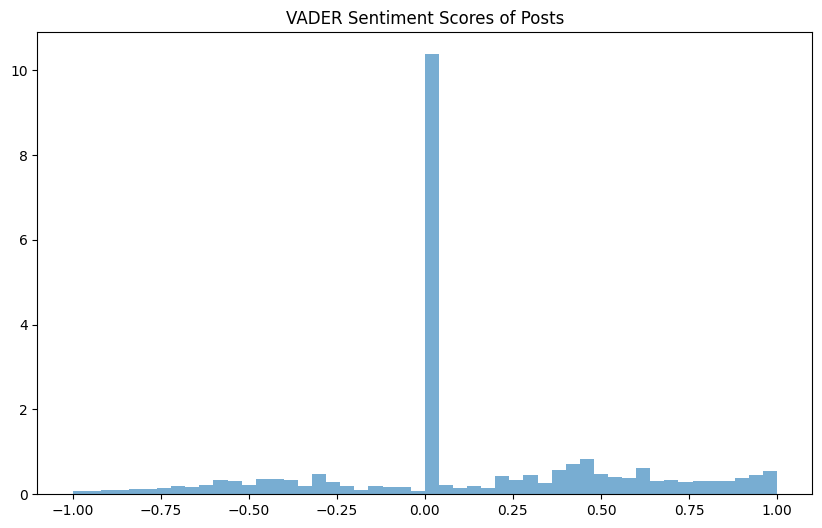

In [25]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# sid = SentimentIntensityAnalyzer()
# posts_df["vader"] = posts_df["clean_text"].apply(lambda t: sid.polarity_scores(t)["compound"])

zero_pct = (posts_df["vader"] == 0).mean() * 100
print(f"{zero_pct:.1f}% of posts got a 0.0 VADER score")

plt.figure(figsize=(10, 6))
plt.hist(posts_df["vader"], bins=50, density=True, alpha=0.6)
plt.title("VADER Sentiment Scores of Posts")

12.1% of posts got a 0.0 VADER score


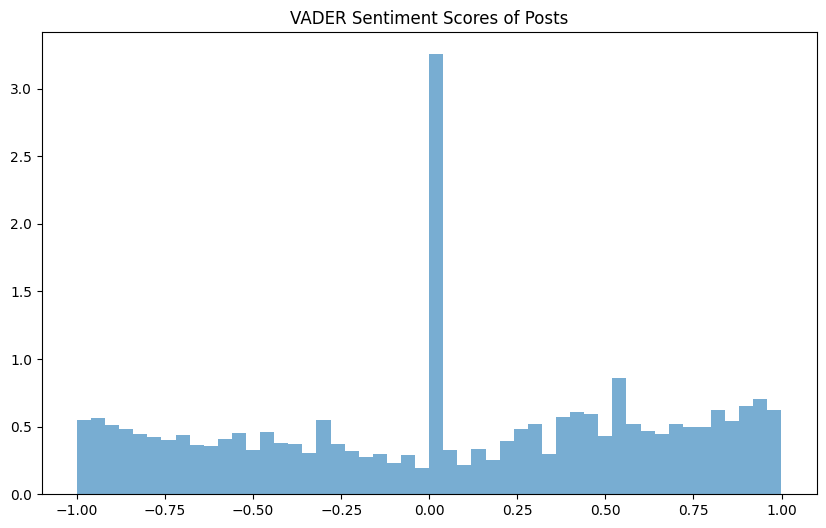

In [26]:
sid = SentimentIntensityAnalyzer()
comments_df["vader"] = comments_df['clean_body'].apply(lambda t: sid.polarity_scores(t)["compound"])

plt.figure(figsize=(10, 6))
plt.hist(comments_df["vader"], bins=50, density=True, alpha=0.6)
plt.title("VADER Sentiment Scores of Posts")

zero_pct = (comments_df["vader"] == 0).mean() * 100
print(f"{zero_pct:.1f}% of posts got a 0.0 VADER score")

In [31]:
def pick_strong_sentiment(df, strong_threshold=0.7, neutral_threshold=0.1):
    """
    Picks posts with strong positive/negative/neutral sentiment.
    """
    neutral_mask = (
        df["vader"].abs() <= neutral_threshold
    )
    strong_mask = (
        df["vader"].abs() >= strong_threshold
    )
    df["weak_label"] = None

    df.loc[neutral_mask, "weak_label"] = "neutral"

    def _pick_label(row):
        s = row.vader
        return "positive" if s > 0 else "negative"

    df.loc[strong_mask & ~neutral_mask, "weak_label"] = (
    df[strong_mask & ~neutral_mask]
      .apply(_pick_label, axis=1)
    )

    df_labeled = df.dropna(subset=["weak_label"]).reset_index(drop=True)
    return df_labeled

In [32]:
posts_labeled = pick_strong_sentiment(posts_df)
print("Posts labeled as weak sentiment:", len(posts_labeled))
posts_labeled["weak_label"].value_counts() 

Posts labeled as weak sentiment: 348910


weak_label
neutral     261331
positive     67293
negative     20286
Name: count, dtype: int64

In [33]:
comments_labeled = pick_strong_sentiment(comments_df)
print("Comments labeled as weak sentiment:", len(comments_labeled))
comments_labeled["weak_label"].value_counts()

Comments labeled as weak sentiment: 1524473


weak_label
positive    552127
neutral     522429
negative    449917
Name: count, dtype: int64

In [35]:
# Save the cleaned and labeled dataframes to new tables in the database
posts_labeled.to_sql("posts_labeled", engine, if_exists="replace", index=False)
comments_labeled.to_sql("comments_labeled", engine, if_exists="replace", index=False)

1524473